In [216]:
import pandas as pd
import re

regex_runs = r"^Start run ([0-9]+)"
runs = []
regex_nodes = r"^node_([0-9]+),([A-Z][a-z]+)"
nodes = []

nodes_count = {}
with open("../../simulation/Data/Throughput.txt", "r") as f:
    for line in f:
        matches_it = re.finditer(regex_runs, line)
        matches = [m[1] for m in matches_it]
        if len(matches) == 1:
            runs.append(int(matches[0]))
            
        matches_it = re.finditer(regex_nodes, line)
        matches = [m for m in matches_it]
        if len(matches) == 1:
            groups = matches[0].groups() 

            num, succeed = int(groups[0]), groups[1]!="False"

            nodes_count[num] = nodes_count.get(num, -1) + 1
            nodes.append((num, succeed, nodes_count[num]))
nodes

[(0, True, 0),
 (0, True, 1),
 (0, True, 2),
 (0, True, 3),
 (0, True, 4),
 (1, True, 0),
 (1, True, 1),
 (1, True, 2),
 (1, True, 3),
 (1, True, 4),
 (10, True, 0),
 (10, True, 1),
 (10, True, 2),
 (10, True, 3),
 (10, True, 4),
 (100, True, 0),
 (100, True, 1),
 (100, True, 2),
 (100, True, 3),
 (100, False, 4),
 (1000, False, 0),
 (1001, False, 0),
 (1002, False, 0),
 (1003, False, 0),
 (1004, False, 0),
 (1005, False, 0),
 (1006, False, 0),
 (1007, False, 0),
 (1008, False, 0),
 (1009, False, 0),
 (101, True, 0),
 (101, True, 1),
 (101, True, 2),
 (101, True, 3),
 (101, False, 4),
 (1010, False, 0),
 (1011, False, 0),
 (1012, False, 0),
 (1013, False, 0),
 (1014, False, 0),
 (1015, False, 0),
 (1016, False, 0),
 (1017, False, 0),
 (1018, False, 0),
 (1019, False, 0),
 (102, True, 0),
 (102, True, 1),
 (102, True, 2),
 (102, True, 3),
 (102, False, 4),
 (1020, False, 0),
 (1021, False, 0),
 (1022, False, 0),
 (1023, False, 0),
 (1024, False, 0),
 (1025, False, 0),
 (1026, False, 0),

In [217]:
def getIncrement(x):
    k = 0
    for r in runs: 
        if x < r:
            return k
        k += 1
    return 0
    

df = pd.DataFrame(nodes, columns=["Nodes", "Succeed", "line"])
display(df["line"].unique())
df["Run"] = df.apply(lambda x: runs[getIncrement(x["Nodes"])+x["line"]], axis=1)
print(runs)
df

array([0, 1, 2, 3, 4])

[50, 250, 500, 750, 1000, 1100]


,Nodes,Succeed,line,Run
0,0,True,0,50
1,0,True,1,250
2,0,True,2,500
3,0,True,3,750
4,0,True,4,1000
...,...,...,...,...
3572,997,False,1,1100
3573,998,True,0,1000
3574,998,False,1,1100
3575,999,True,0,1000


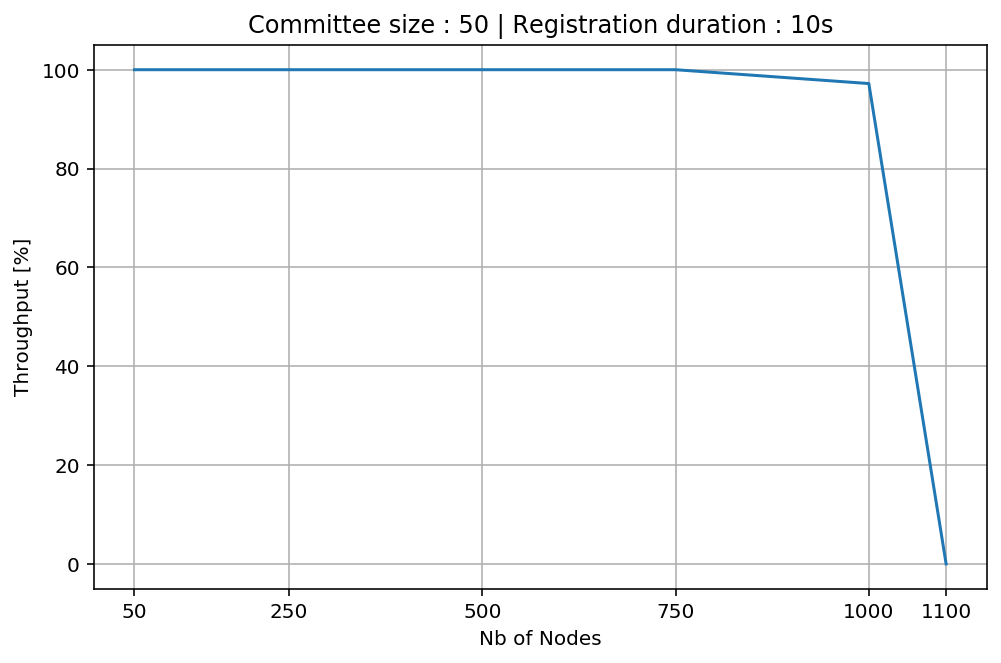

In [228]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
vals = []
plt.figure(figsize=(8,5))
for r in runs:
    dfr = df.loc[df["Run"]==r]
    if df.loc[df["Run"]==r].shape[0] > 0:
        vals.append(dfr.loc[df["Succeed"]==True].shape[0]/r*100)
        
plt.plot(runs, vals)
plt.xlabel("Nb of Nodes")
plt.ylabel("Throughput [%]")
plt.xticks(runs)
plt.grid(True)
plt.title("Committee size : 50 | Registration duration : 10s")

plt.savefig("10computer-1.pdf")
plt.show()


# One node point of view

In [225]:
new_run = "Joined,Epoch"
runs_nodes = []
regex_nodes = r"^node_([0-9]+),"
nodes = []

nodes_count = {}
with open("../../simulation/Data/SignerSetnode_0.txt", "r") as f:
    for line in f:
        if line.strip() == new_run:
            if len(nodes) != 0:
                runs_nodes.append(nodes)
                nodes = []
        else:  
            matches_it = re.finditer(regex_nodes, line)
            matches = [m for m in matches_it]
            
            if len(matches) == 1:
                groups = matches[0].groups() 
                num = int(groups[0])
                nodes.append(num)
runs_nodes.append(nodes)


In [226]:
print(runs)
print([len(l) for l in runs_nodes])
for r, l in zip(runs, runs_nodes):
    print(len(l)/r)

[50, 250, 500, 750, 1000, 1100]
[50, 250, 500, 750]
1.0
1.0
1.0
1.0
